In [1]:
# libabries for data exploration.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helpful_functions import MLFunctions

# time series specific libararies
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.offsetbox import AnchoredText
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    usecols=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'],
                    index_col=['date'], 
                    parse_dates=['date'],
                    date_format="%d.%m.%Y")

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2935849 entries, 2013-01-02 to 2015-10-03
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   shop_id       int64  
 1   item_id       int64  
 2   item_price    float64
 3   item_cnt_day  float64
dtypes: float64(2), int64(2)
memory usage: 112.0 MB


In [4]:
sales = sales.sort_index()
helper_function = MLFunctions(sales)
arr = helper_function.dateNum()
sales['time'] = arr

In [5]:
sales.head()

,shop_id,item_id,item_price,item_cnt_day,time
date,,,,,
2013-01-01,18,5823,2500.0,1.0,0
2013-01-01,27,5573,849.0,1.0,0
2013-01-01,7,1006,399.0,1.0,0
2013-01-01,19,17707,899.0,1.0,0
2013-01-01,14,19548,149.0,1.0,0


In [6]:
date_shop_sum = sales.groupby(['date','shop_id']).sum()[['item_cnt_day']]
date_shop_count = sales.groupby(['date','shop_id']).nunique()[['item_id']]
date_shop_mean = sales.groupby(['date','shop_id']).mean()[['item_price']]
date_shop_median = sales.groupby(['date','shop_id']).median()[['time']]
sales_ = pd.concat([date_shop_sum, date_shop_count, date_shop_mean, date_shop_median], axis=1)

In [7]:
sales_ = sales_.reset_index()
sales_.index = sales_['date']

<Axes: xlabel='time', ylabel='item_cnt_day'>

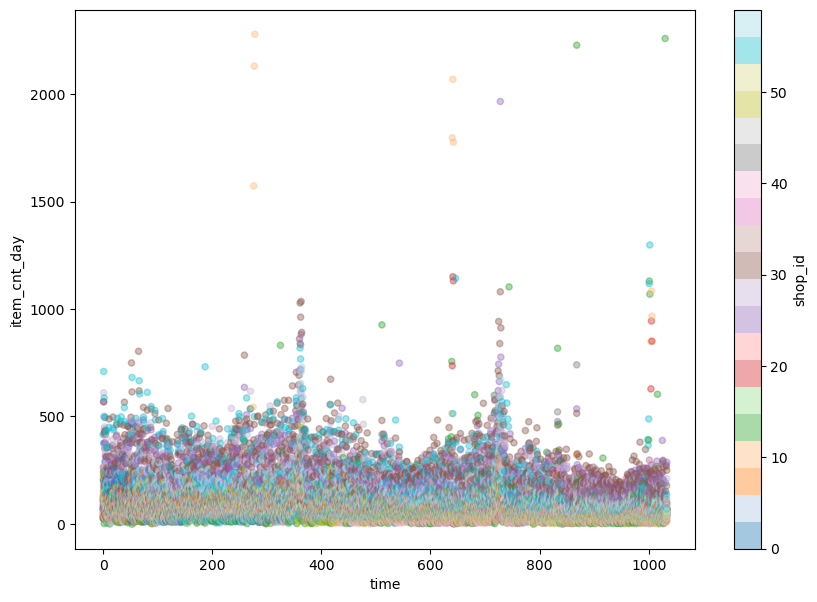

In [8]:
sales_.plot(kind='scatter',x='time', y="item_cnt_day", alpha=0.4, figsize=(10,7),
c="shop_id", cmap=plt.get_cmap("tab20"), colorbar=True,
)
